# Reflection with LangChain (Tweet Generator)

In [1]:
pip install --upgrade -q openai langchain langchain-openai langchain-community langgraph


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# pip install -q langsmith

## Generate

In [3]:
# loading the API keys
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [4]:
# importing the necessary libraries
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

In [5]:
# creating a chat prompt template
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are a Twitter expert assigned to craft outstanding tweets.
            Generate the most engaging and impactful tweet possible based on the user's request.
            If the user provides feedback, refine and enhance your previous attempts accordingly for maximum engagement.''',
        ),
        MessagesPlaceholder(variable_name='messages'),
    ]
)

llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0.7)

# using LCEL to create the generate_chain
generate_chain  = generation_prompt | llm

In [6]:
generate_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [7]:
tweet = ''
request = HumanMessage(
    content='FIFA World Cup 26'
)

for chunk in generate_chain.stream(
    {'messages': [request]}
): 
    print(chunk.content, end='')
    tweet += chunk.content

🏆 Get ready for the ultimate showdown! The FIFA World Cup 2026 is set to be a historic celebration of soccer, uniting fans across the globe! 🌍⚽️ From thrilling matches to unforgettable moments, who are you rooting for? Let the countdown begin! #WorldCup2026 #SoccerUnites #DreamBig 🌟

## Reflect and Repeat

In [8]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are a Twitter influencer known for your engaging content and sharp insights.
            Review and critique the user’s tweet.
            Provide constructive feedback, focusing on enhancing its depth, style, and overall impact.
            Offer specific suggestions to make the tweet more compelling and engaging for their audience.'''
        ),
        MessagesPlaceholder(variable_name='messages'),
    ]
)

reflect_chain  = reflection_prompt | llm

In [9]:
reflect_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [10]:
reflection = ''
# streaming the response
for chunk in reflect_chain.stream(
    {'messages': [request, HumanMessage(content=tweet)]}
):
    print(chunk.content, end='')
    reflection += chunk.content


This tweet certainly captures the excitement surrounding the FIFA World Cup 2026, but there are some areas where you could enhance its depth, style, and overall impact. Here are a few suggestions:

1. **Add a Personal Touch**: Consider sharing a personal connection to the World Cup or a memorable experience from past tournaments. This can create a stronger bond with your audience.

   **Example**: “I still remember the thrill of [specific moment from a past World Cup]. Who else is feeling that excitement as we gear up for #WorldCup2026? 🌍⚽️”

2. **Engage with a Question**: You’ve asked who people are rooting for, which is great! You could deepen engagement by asking more specific questions, like favorite teams or players, or even predictions.

   **Example**: “Which underdog team do you think will surprise us this year? Let’s hear your predictions! #WorldCup2026”

3. **Use Strong Visuals**: While emojis add flair, consider incorporating a striking image or GIF related to the World Cup 

In [11]:
for chunk in generate_chain.stream(
    {'messages': [request, AIMessage(content=tweet), HumanMessage(content=reflection)]}
):
    print(chunk.content, end='')

Absolutely love the feedback! Here’s a revised tweet that incorporates your suggestions for more depth, engagement, and excitement:

🏆 As we gear up for the epic clash of titans at #WorldCup2026, I can't help but reminisce about the thrill of 2014's last-minute goal! 🌍⚽️ Who are you rooting for this year, and which underdog team do you think will surprise us? Tag your soccer buddies and let’s make this countdown unforgettable! 🌟 Did you know the first World Cup was held in 1930? Let’s celebrate the rich history of this incredible tournament together! #SoccerUnites #DreamBig

What do you think? Ready to spark some conversation?

## Define the Graph

In [12]:
from typing import List, Sequence
from langgraph.graph import END, MessageGraph

In [13]:
# defining a function for the generation node
def generation_node(state: Sequence[BaseMessage]):
    return generate_chain.invoke({'messages': state})

# defining a function for the reflection node
def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # messages we need to adjust
    cls_map = {'ai': HumanMessage, 'human': AIMessage}
    # First message is the original user request. We keep it the same for all nodes
    translated = [messages[0]] + [
    cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = reflect_chain.invoke({'messages': translated})
    # We treat the output (AI message) of this as human feedback for the generator
    return HumanMessage(content=res.content)

# initializing the MessageGraph and adding two nodes to the graph: generate and reflect.
builder = MessageGraph()
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)

# setting the generate node as the starting point
builder.set_entry_point('generate')

MAX_ITERATIONS = 5
def should_continue(state: List[BaseMessage]):
    if len(state) > MAX_ITERATIONS:
        return END
    return 'reflect'

# adding a conditional edge to the graph
builder.add_conditional_edges('generate', should_continue)
builder.add_edge('reflect', 'generate')

# compiling the graph
graph = builder.compile()

/tmp/ipykernel_133465/2297294772.py:18: LangGraphDeprecatedSinceV10: MessageGraph is deprecated in LangGraph v1.0.0, to be removed in v2.0.0. Please use StateGraph with a `messages` key instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  builder = MessageGraph()


In [17]:
# !!! See below how to upgrade the code for the latest version of LangGraph and remove the warning above

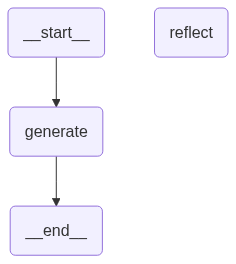

In [14]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Running the App

In [15]:
inputs = HumanMessage(content='Generate a tweed about FIFA World Cup 26')
response = graph.invoke(inputs)

In [16]:
for resp in response:
    print(resp.content)
    print('\n' + '-' * 100 + '\n')

Generate a tweed about FIFA World Cup 26

----------------------------------------------------------------------------------------------------

🌍⚽ Countdown to the #FIFAWorldCup2026! 🎉 Get ready for the ultimate football festival as three nations unite to host the world's greatest sporting event! 🇺🇸🇨🇦🇲🇽 Who are you cheering for? Let the excitement begin! 🏆🔥 #WorldCup2026 #FootballFever

----------------------------------------------------------------------------------------------------

Your tweet sets a vibrant tone and effectively engages your audience with emojis and hashtags! However, we can enhance its depth and style to make it more impactful. Here’s a critique and some suggestions:

### Critique & Suggestions:

1. **Depth and Insight**:
   - While the excitement is palpable, consider adding a fact or interesting statistic about the World Cup 2026. For instance, you could mention the number of teams participating or the significance of hosting across three countries.
   - Suggest

### Code Upgrade for the latest version of LangGraph

In [22]:
# 1. Define your state schema
# First, define a TypedDict to structure your state, with the "messages" key to accumulate messages via a reducer like add_messages.
# This ensures that each node’s messages get appended, not overwritten. 

from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# Assume you already have these chains defined above:
# generate_chain, reflect_chain

# ---- State schema ----
class State(TypedDict):
    # Accumulate messages across nodes
    messages: Annotated[list[BaseMessage], add_messages]

    
# 2. Define your nodes as State → State transitions

# ---- Nodes ----
def generation_node(state: State) -> dict:
    """Call the generator with the running message history and append its reply."""
    ai_msg: BaseMessage = generate_chain.invoke({"messages": state["messages"]})
    return {"messages": [ai_msg]}

def reflection_node(state: State) -> dict:
    """
    Reflect on the conversation so far and append feedback as a HumanMessage
    (so the generator treats it like human guidance).
    """
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    msgs = state["messages"]
    translated = [msgs[0]] + [cls_map[m.type](content=m.content) for m in msgs[1:]]
    res: BaseMessage = reflect_chain.invoke({"messages": translated})
    return {"messages": [HumanMessage(content=res.content)]}

# ---- Control flow ----
MAX_ITERATIONS = 3

def should_continue(state: State):
    """Stop after MAX_ITERATIONS generated messages, otherwise go to 'reflect'."""
    if len(state["messages"]) > MAX_ITERATIONS:
        return END
    return "reflect"


# 3. Build your StateGraph instead of MessageGraph

# ---- Build graph ----
builder = StateGraph(state_schema=State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)

builder.set_entry_point("generate")
builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")

# ---- Compile ----
graph = builder.compile()


In [23]:
from langchain_core.messages import HumanMessage

# NEW: pass a state dict with a "messages" list
inputs = {"messages": [HumanMessage(content="Generate a tweet about FIFA World Cup 26")]}

# Invoke the graph and get the final state back
final_state = graph.invoke(inputs)

# Print all messages in the final state
for msg in final_state["messages"]:
    print(msg.content)
    print("\n" + "-" * 100 + "\n")


Generate a tweet about FIFA World Cup 26

----------------------------------------------------------------------------------------------------

🌍⚽️ Get ready for the ultimate showdown! The FIFA World Cup 2026 is coming to North America! 🇺🇸🇨🇦🇲🇽 Who will lift the trophy? 🏆 Let the countdown begin as we celebrate the beautiful game and unite fans from all over the globe! #FIFAWorldCup2026 #SoccerLove #OneGameOneDream

----------------------------------------------------------------------------------------------------

Your tweet captures the excitement around the FIFA World Cup 2026 well, and the use of emojis adds a fun touch! However, there are a few ways you could enhance its depth and engagement:

1. **Add a Unique Angle**: Instead of a general call to action, consider highlighting something specific about the tournament, like its historical significance, the diversity of host countries, or a star player to watch.

2. **Pose a Question**: Engage your audience more directly by asking t